Figure for Simon's paper in JGR.
Altimetry data from ftp://my.cmems-du.eu/Core/SEALEVEL_MED_PHY_L4_REP_OBSERVATIONS_008_051/dataset-duacs-rep-medsea-merged-allsat-phy-l4/2014/

In [1]:
import os
import glob
import json
import logging
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from collections import OrderedDict
import alborexdata
from importlib import reload
import medgib_functions

In [2]:
reload(medgib_functions)

<module 'medgib_functions' from '/home/ctroupin/Publis/201703_AlborexData/python/medgib_functions.py'>

# Configuration
Most of the configuration (file paths, domain, resolution, ...) is done in the json file [`alborexconfig.json`](./alborexconfig.json).

In [3]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)

## Logger

In [4]:
logger = alborexdata.configure_logging()
logger.setLevel(logging.DEBUG)
logging.info("Starting")

### Figures

In [5]:
figdir = config["figdir"]

## Domain

In [6]:
coordinates = config["domain"]["coordinates1"]
coordinates2 = config["domain"]["coordinates2"]
dlon, dlat = config["domain"]["coordinates1"][0], config["domain"]["coordinates1"][1]

In [7]:
config["domain"]["coordinates1"]

[-6.75, 3.001, 34.75, 40.0]

### Labels

In [8]:
labelDic = OrderedDict([("Cartagena", (37.6, -0.983333)),
                       ("Almería", (36.840278, -2.468056)),
                       ("Oran", (35.696944, -0.633056)),
                       ("Cape Three Forks", (35.438333, -2.974444)),
                       ("Strait of Gibraltar", (35.966667, -5.483333)),
                       ("Alboran Sea", (36.45, -3.5)),
                       ("SPAIN", (37.7, -2.5)),
                       ("AFRICA", (35., -5.6))
                       ])

In [9]:
def add_places(m, labelDic):
    """
    Add labels of different places
    """
    dx = 0.05
    dy = 0.05
    for ip, places in enumerate(labelDic):
        
        lonT, latT = m(labelDic[places][1], labelDic[places][0])

        if ip <2:
            lonT2, latT2 = m(labelDic[places][1] + dx, labelDic[places][0] + dy)
            plt.text(lonT2, latT2, places, fontsize=14, zorder=3,
                     ha="center", va="bottom",
                     bbox=dict(facecolor='white', edgecolor="w", alpha=0.55))
            plt.plot(lonT, latT, "ko", zorder=4)
        elif ip < 4:
            lonT2, latT2 = m(labelDic[places][1] + dx, labelDic[places][0] - dy)
            plt.text(lonT2, latT2, places, fontsize=14, zorder=3,
                     ha="center", va="top",
                     bbox=dict(facecolor='white', edgecolor="w", alpha=0.55))
            plt.plot(lonT, latT, "ko", zorder=4)
        elif ip <= 5: 
            plt.text(lonT, latT, places, fontsize=16, ha="center", va="center",
                     bbox=dict(facecolor='white', edgecolor="w", alpha=0.75))
        else:
            plt.text(lonT, latT, places, fontsize=18, ha="center", va="center")

In [10]:
def decorate_map(m, coordinates, dlon, dlat):
    
    # Coastline and continent
    for i in range(0, len(loncoast)):
        m.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
               color='k', linewidth=.25, latlon=True)
    m.fillcontinents(ax=ax, color='0.9', zorder=2)
    m.drawcountries(linewidth=.2, color="k")

    # Grid
    alborexdata.add_map_grid(m, coordinates, dlon=2., dlat=2.,
                             fontname='Times New Roman', fontsize=14, 
                             linewidth=0.2, zorder=1, color=".6")
    # Scale
    m.drawmapscale(-0.45, 35.1, -0.25, 35.1, 100, barstyle='simple', 
               units='km', fontsize=12, zorder=3)

In [11]:
def add_fronts(m):
    """
    Add fronts: Cartagena, Almeria-Oran and AlboRex
    """
    p1 = (labelDic["Cartagena"][1], labelDic["Cartagena"][0])
    p2 = (.379, 36.23)
    lon1, lat1 = m(p1[0], p1[1])
    lon2, lat2 = m(p2[0], p2[1])
    plt.plot((lon1, lon2), (lat1, lat2), 'r--', label="Cartagena front")

    p1 = (labelDic["Almería"][1], labelDic["Almería"][0])
    p2 = (labelDic["Oran"][1], labelDic["Oran"][0])
    lon1, lat1 = m(p1[0], p1[1])
    lon2, lat2 = m(p2[0], p2[1])
    plt.plot((lon1, lon2), (lat1, lat2), 'b--', label="Almeria-Oran front")

    m.plot(f.lon, f.lat, "k--", linewidth=2, latlon=True, label="AlborEx front (from SST image)")
    plt.legend(fontsize=14)

# Load data
## Coast

In [12]:
loncoast, latcoast = alborexdata.read_lonlat_coast(config["datafiles"]["coast"])

## Front

In [13]:
frontcoords = "../data/front_coordinates.dat"
f = alborexdata.Front()
f.get_from_file(frontcoords)
f.smooth()

### Gyres

In [14]:
WAG = medgib_functions.Gyre(-4.25, 35.75, 55., "WAG")
EAG = medgib_functions.Gyre(-2.1, 35.8, 49., "EAG")
AlborexEddy = medgib_functions.Gyre(-0.9, 36.5, 52.5, "AlborEx\neddy")

# Create the figure

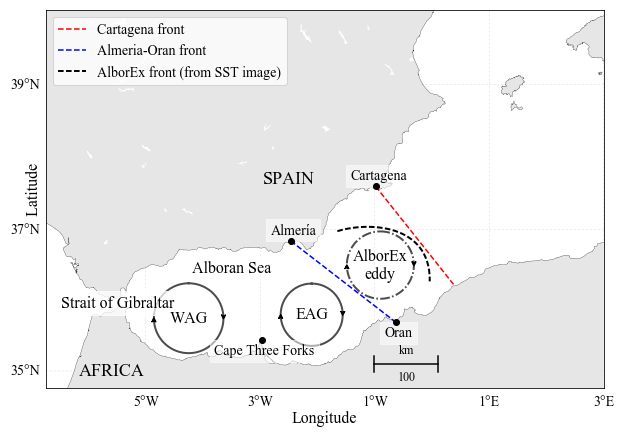

In [16]:
figname = os.path.join(figdir, 'front_schema06')
fig, m, ax = alborexdata.prepare_map(coordinates, 'h')

fig.set_size_inches(10, 10)
m.plot(0, 0)
add_places(m, labelDic)
decorate_map(m, coordinates, dlon, dlat)

myarrowdict = dict(arrowstyle="fancy", fc="k")
WAG.add_to_map(m=m, arrowprops=myarrowdict, lw=2., color='k', alpha=0.7)
EAG.add_to_map(m=m, arrowprops=myarrowdict, lw=2., color='k', alpha=0.7)
AlborexEddy.add_to_map(m=m, arrowprops=myarrowdict, lw=2., 
                       color='k', alpha=0.7, linestyle='-.')

add_fronts(m)

plt.xlabel("\nLongitude", fontsize=16)
plt.ylabel("\n     Latitude", fontsize=16)

plt.savefig(figname, dpi=300, bbox_inches='tight', transparent=False,
            edgecolor='white', pad_inches=0)
plt.show()
plt.close()

In [80]:
figname = os.path.join(figdir, 'front_schema01')
fig, m, ax = alborexdata.prepare_map(coordinates, 'i')
fig.set_size_inches(10, 10)

add_places(m, labelDic)
decorate_map(m, coordinates, dlon, dlat)

add_fronts(m)
altimetry.plot_sla(m)

plt.savefig(figname, dpi=300, bbox_inches='tight', transparent=False,
             edgecolor='white', pad_inches=0)
plt.show()
plt.close()

NameError: name 'altimetry' is not defined

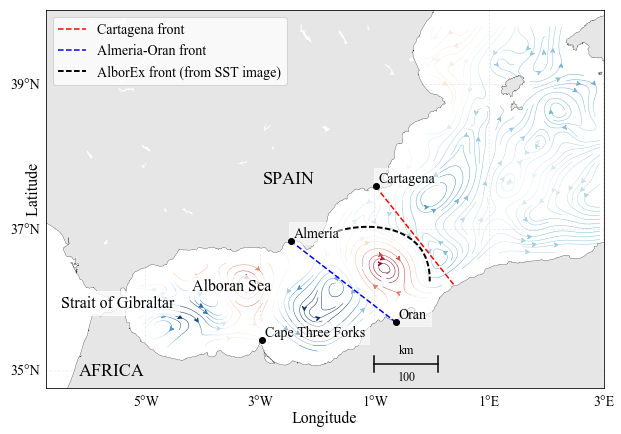

In [154]:
figname = os.path.join(figdir, 'front_schema05')
fig, m, ax = alborexdata.prepare_map(coordinates, 'h')
fig.set_size_inches(10, 10)

add_places(m, labelDic)
decorate_map(m, coordinates, dlon, dlat)

add_fronts(m)
altimetry.plot_streamline(m)

plt.xlabel("\nLongitude", fontsize=16)
plt.ylabel("\n     Latitude", fontsize=16)
plt.savefig(figname, dpi=300, bbox_inches='tight', transparent=False,
            edgecolor='white', pad_inches=0)
plt.show()
plt.close()